# Felügyelet nélküli tanulás
Főkomponenselemzés, K-közép klaszterezés

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from seaborn import scatterplot as scatter
import math
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters; register_matplotlib_converters()
from fcmeans import FCM

### Adatok beolvasása

    vszam - hányszor vettek adott termékből
    bevetel - összesen mennyi bevételt hozott a termék
    haszonkulcs - hány százalék haszon van a terméken
    vnap - hány napja vásárolták utóljára a terméket

In [2]:
termek_tulajdonsag = pd.read_csv('termek_tulajdonsag.csv', header=0, sep=',')

df_termek = termek_tulajdonsag.set_index('z_soid')

df_termek.loc[df_termek['haszonkulcs']>200, 'haszonkulcs'] = 200

df_termek.head()

,vszam,bevetel,haszonkulcs,vnap
z_soid,,,,
1,28,3348739.0,11.565714,1199
2,1,110228.0,10.110000,1884
3,49,695098.0,8.902449,7
4,37,665054.0,7.545676,0
5,1,101496.0,8.500000,940


### Előkészítés: soroljuk be az árakat 0...3 kategórákba

In [3]:
arak = pd.DataFrame(df_termek['bevetel'] / df_termek['vszam'], columns=['ar']).round()

def choose_boost(n):
    if(n<29990):
        return 0
    elif(n>=29990 and n<51077):
        return 1
    elif(n>=51077 and n<83330):
        return 2
    else:
        return 3
        
arak['cat'] = [choose_boost(n) for n in arak['ar']]

#df_termek = pd.concat([df_termek, arak['ar']], axis=1)

scaled_termek = preprocessing.scale(df_termek)

### Fuzzy C-means
Klaszterelemzés fuzzy klaszterekkel

In [4]:
fcm = FCM(n_clusters=5, random_state=42, max_iter=1000)
fcm.fit(scaled_termek)

fcm_centers = fcm.centers
u = pd.DataFrame(fcm.u)
fcm_labels  = fcm.u.argmax(axis=1)

y_pred_fuzzy = fcm.predict(scaled_termek)

print("FCM predikciók")
print(fcm.u[:10])
print()
print("Becsült értékek")
for i in range(10):
    print(y_pred_fuzzy[i])

FCM predikciók
[[0.17271005 0.27398653 0.2114093  0.14576227 0.19613186]
 [0.08094442 0.03422782 0.66323582 0.07910315 0.14248879]
 [0.31169221 0.19725168 0.09581849 0.1982288  0.19700883]
 [0.41121253 0.10681799 0.07863771 0.20134899 0.20198279]
 [0.1017332  0.01505852 0.42223107 0.08338771 0.37758951]
 [0.01037813 0.0028701  0.95173364 0.01021022 0.02480791]
 [0.85120761 0.00649478 0.01372316 0.05750837 0.07106608]
 [0.17736188 0.01187177 0.09230925 0.096186   0.6222711 ]
 [0.47289928 0.06567204 0.06558803 0.20112837 0.19471228]
 [0.82832675 0.00773646 0.01485085 0.07727192 0.07181402]]

Becsült értékek
1
2
0
0
2
2
0
4
0
0


### Optimális klaszterszám megtalálása

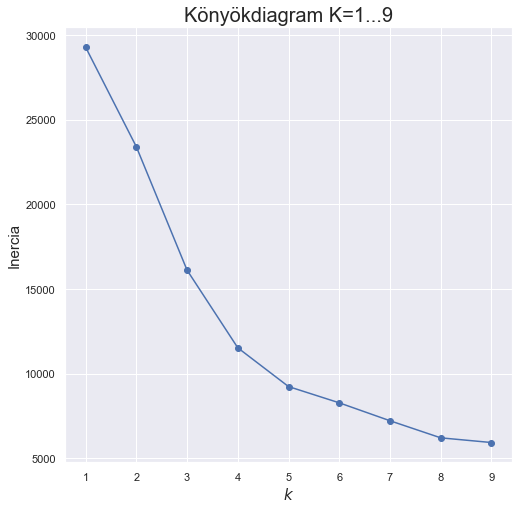

In [5]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, init='k-means++', n_init=1, 
                       random_state=42).fit(scaled_termek) for k in range(1,10)]

inertia = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8,8))
plt.title("Könyökdiagram K=1...9", size=20)
plt.plot(range(1,10), inertia, 'bo-')
plt.xlabel('$k$', fontsize=15)
plt.ylabel('Inercia', fontsize=15)
plt.show()

### Sziluett módszer

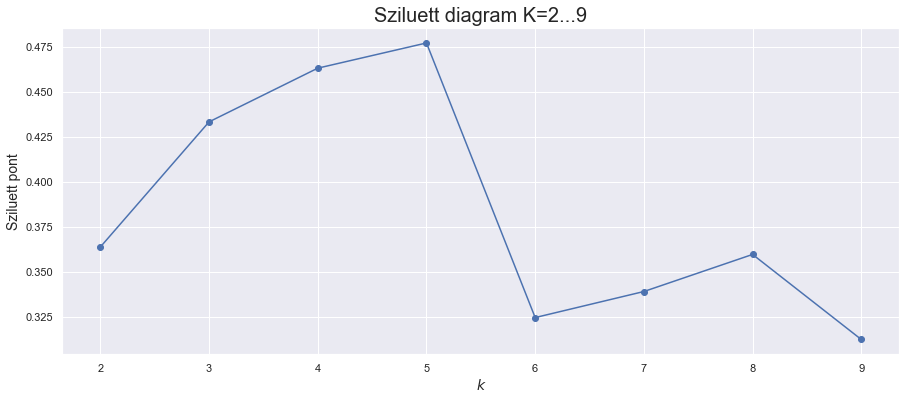

In [6]:
from sklearn.metrics import silhouette_score

silhouettes = [silhouette_score(scaled_termek, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(15,6))
plt.title("Sziluett diagram K=2...9", size=20)
plt.plot(range(2,10), silhouettes, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Sziluett pont', fontsize=14)
plt.show()

### K-Means 5 klaszterrel

In [7]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=1000, random_state=42)
kmeans.fit(scaled_termek)

print('Inercia:', kmeans.inertia_)

y_pred = kmeans.predict(scaled_termek)

y_pred[:10]

Inercia: 9239.392317786012


array([2, 1, 2, 2, 1, 1, 0, 0, 0, 0])

### Főkomponenselemzés

In [8]:
from sklearn.decomposition import PCA

var_ratio = 2
pca = PCA(n_components=var_ratio)
pca.fit(scaled_termek)
pca_data = pca.transform(scaled_termek)

print('Főkomponensek száma: ', pca.n_components_)
print('Megőrzött varianciahányad: ', np.sum(pca.explained_variance_ratio_))

Főkomponensek száma:  2
Megőrzött varianciahányad:  0.7075336950581794


### PCA vizualizálása

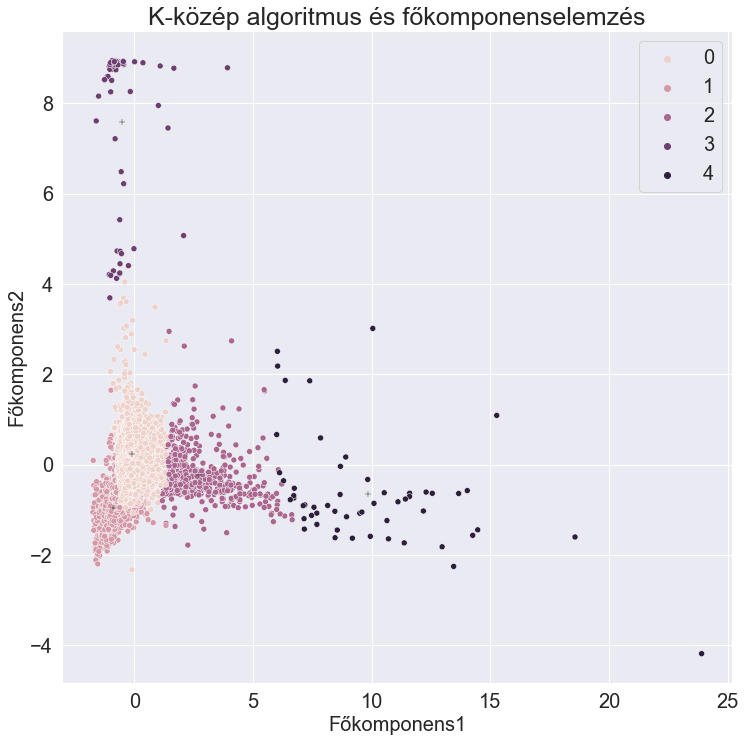

In [11]:
fs=20 # betűméret

create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns = [str(x) for x in range(pcd.shape[1])])

pca_frame = create_pca_frame(pca_data)

pca_frame['pred'] = pd.Series(y_pred) #Klaszterek 

# pca_frame['pred'] = pd.Series(y_pred_fuzzy) #Fuzzy C-means klaszterek

#cluster center
centers = kmeans.cluster_centers_
pca_centers = pd.DataFrame(pca.transform(centers), columns=['0','1'])

plt.figure(figsize=(12,12))
plt.title('K-közép algoritmus és főkomponenselemzés', size=fs+5)
# cmap = sns.color_palette("bright")[:5]
ax = scatter(x='0', y='1', hue='pred', data=pca_frame)
ax = scatter(x='0', y='1', color=".2", marker="+", data=pca_centers)
ax.legend(loc='upper right', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_xlabel('Főkomponens1', size=fs)
ax.set_ylabel('Főkomponens2', size=fs)
plt.show()

### Sziluett diagramok

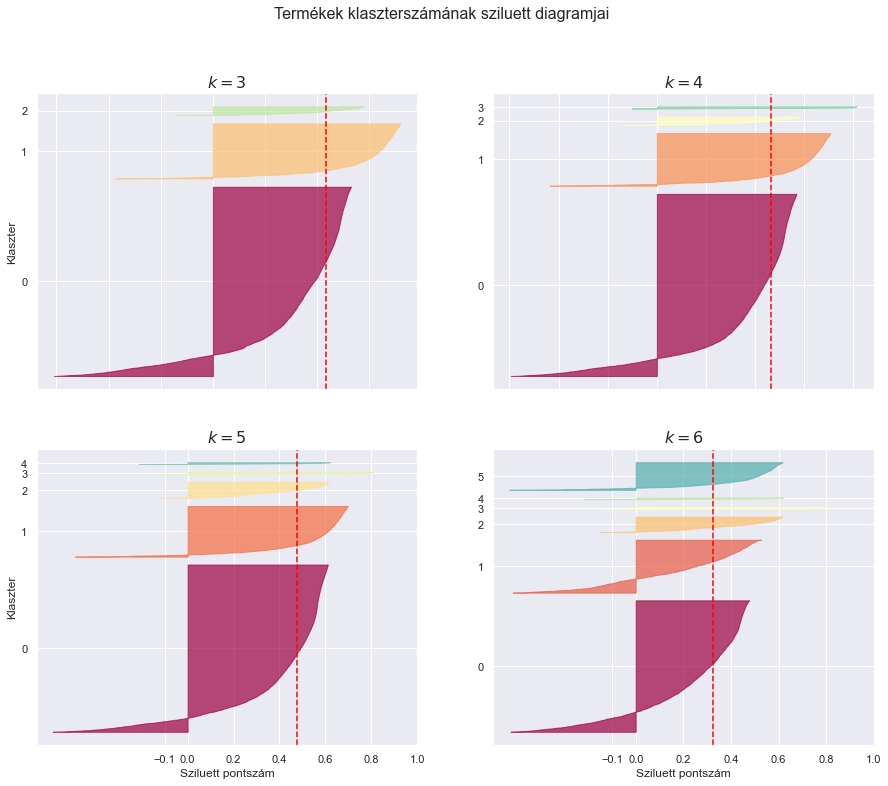

In [12]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(15,12))

for k in (3,4,5,6):
    plt.subplot(2, 2, k-2)
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coeffs = silhouette_samples(pca_data, y_pred)
    
    padding = len(pca_data) // 30
    
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos+len(coeffs)), 0, coeffs, facecolor=color, 
                          edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos+=len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if k in (3,5):
        plt.ylabel('Klaszter')
    
    if k in (5,6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Sziluett pontszám')
    else:
        plt.tick_params(labelbottom=False)
        
    plt.axvline(x=silhouettes[k-2], color="red", linestyle='--')
    plt.title('$k={}$'.format(k), fontsize=16)

plt.suptitle('Termékek klaszterszámának sziluett diagramjai', fontsize=16)
plt.show()

### Loading Score: mennyiben felel a varianciáért adott változó

In [13]:
loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

loadings = pd.Series(loading_scores)
factors = pd.Series(df_termek.columns)
print(pd.concat([loadings, factors], axis=1))

          0            1
0  0.666689        vszam
1  0.662194      bevetel
2 -0.072784  haszonkulcs
3 -0.334256         vnap


### Scree Plot: adott főkomponens mennyiben felel a varianciáért

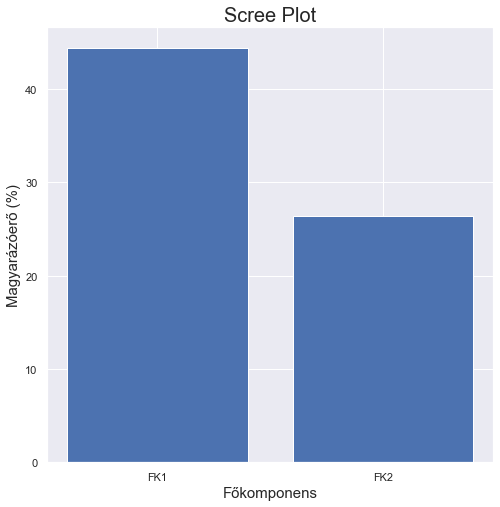

In [14]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['FK' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(8,8))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Magyarázóerő (%)', size=15)
plt.xlabel('Főkomponens', size=15)
plt.title('Scree Plot', size=20)
plt.show()

### Klaszterek leírása statisztikailag

In [15]:
df_cluster = df_termek.copy().reset_index()

df_cluster['pred'] = pd.Series(y_pred)
df_cluster['cat'] = pd.Series(arak.reset_index()['cat'])

n = kmeans.n_clusters

df_stat = pd.DataFrame()
for i in range(n):
    stat = df_cluster[df_cluster['pred']==i][['vszam','bevetel','haszonkulcs','vnap']].describe()    
    df_stat = pd.concat([df_stat, stat], axis=0)

df_stat.index = [str(y)+'_'+str(int(x/8)) for x,y in zip(range(len(df_stat)), df_stat.index)]
df_stat = df_stat.sort_index(axis=0)

dict_stat = {j:df_stat.iloc[i:i+n,:] for i,j in zip(range(0, n*8, n), ['25','50','75','count','max',
                                                                       'mean','min','std'])}

dict_stat

{'25':        vszam    bevetel  haszonkulcs   vnap
 25%_0    2.0    10549.0    10.452214   22.0
 25%_1    1.0    25063.0     8.903929  471.0
 25%_2   25.0  1249942.5     8.497871    5.0
 25%_3    2.0     5656.0   145.685476   12.5
 25%_4  115.5  3832899.5     8.526571    2.5,
 '50':        vszam    bevetel  haszonkulcs   vnap
 50%_0    4.0    76480.0    20.138889   79.0
 50%_1    2.0    84204.5    14.936000  584.0
 50%_2   40.0  1867600.5    11.359565   16.0
 50%_3    5.0    22632.0   200.000000   56.0
 50%_4  151.0  5978232.0    12.968376    9.0,
 '75':        vszam    bevetel  haszonkulcs    vnap
 75%_0    8.0   282856.5    30.170000  190.00
 75%_1    4.0   212872.0    20.742500  778.00
 75%_2   58.0  2754000.0    16.154692   51.25
 75%_3   10.0    87037.0   200.000000  323.00
 75%_4  207.5  7874506.5    23.196868   20.00,
 'count':           vszam  bevetel  haszonkulcs    vnap
 count_0  4162.0   4162.0       4162.0  4162.0
 count_1  1676.0   1676.0       1676.0  1676.0
 count_2   48

### Klaszterek leíró statisztikáinak vizualizálása

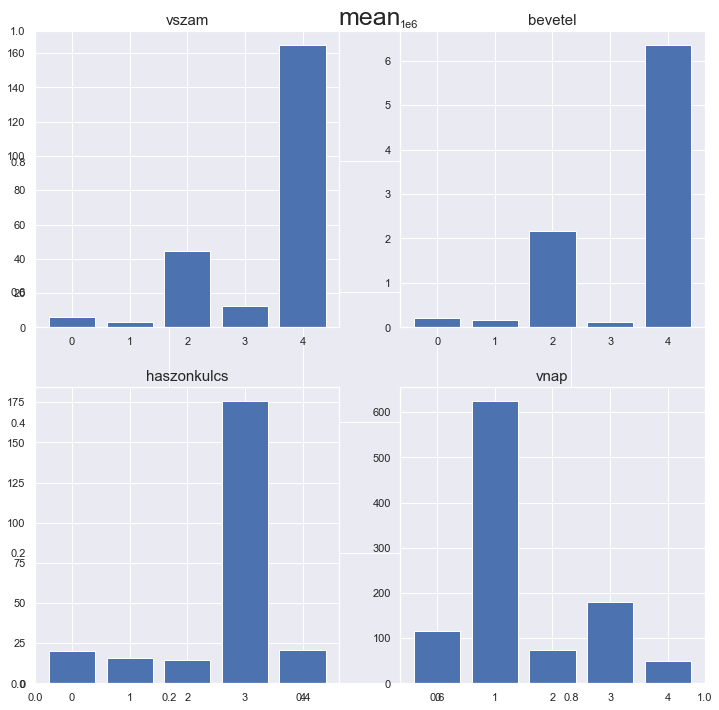

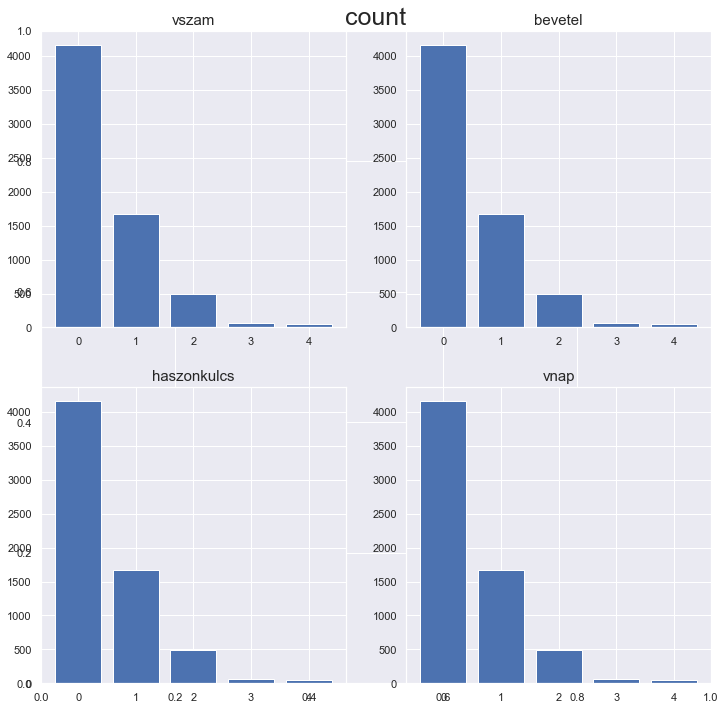

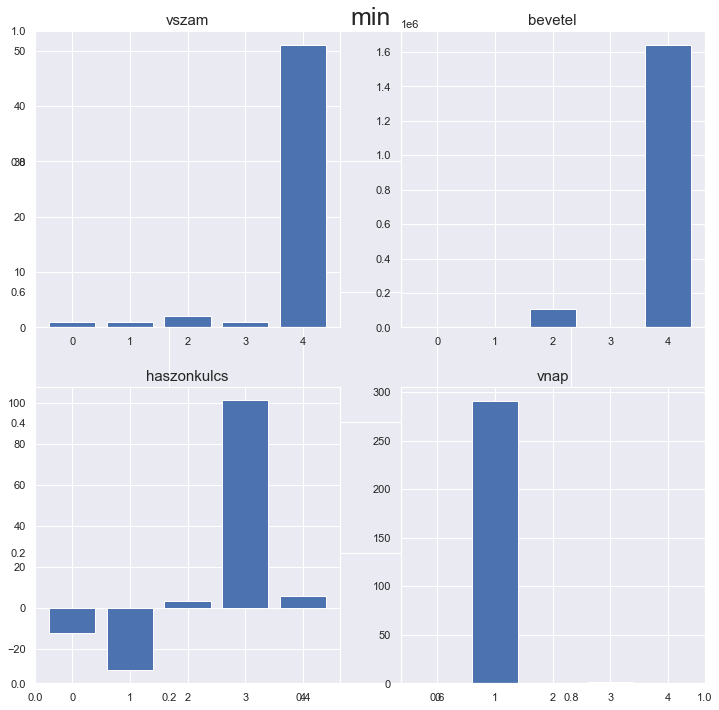

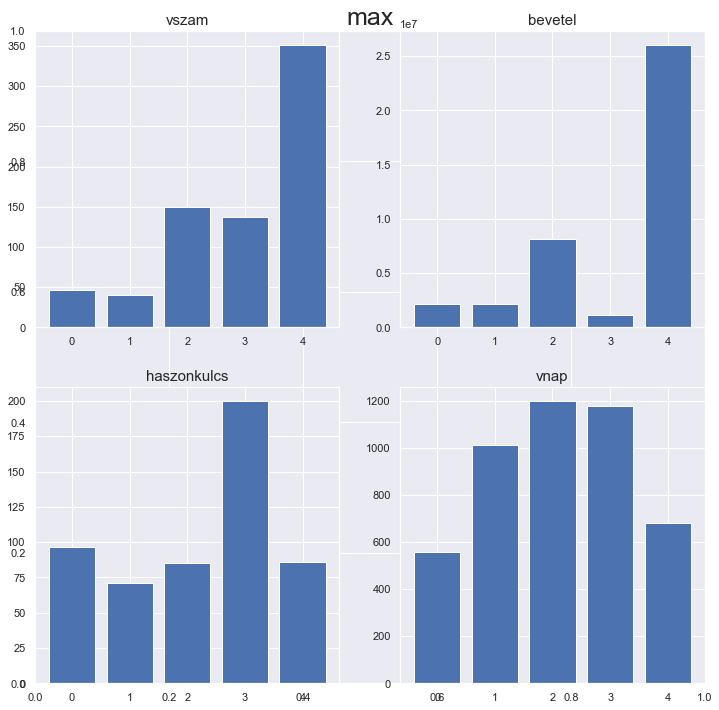

In [16]:
def print_stat(prop, j):
    fig = plt.figure(figsize=(12,12))
    plt.title(prop, size=25)
    ax0 = fig.add_subplot(j,2,1)
    ax1 = fig.add_subplot(j,2,2)
    ax2 = fig.add_subplot(j,2,3)
    ax3 = fig.add_subplot(j,2,4)
    #ax4 = fig.add_subplot(j,2,5)
    ax0.bar(range(5),dict_stat[prop]['vszam'])
    ax0.set_title('vszam', size=15)
    ax1.bar(range(5),dict_stat[prop]['bevetel'])
    ax1.set_title('bevetel', size=15)
    ax2.bar(range(5),dict_stat[prop]['haszonkulcs'])
    ax2.set_title('haszonkulcs', size=15)
    ax3.bar(range(5),dict_stat[prop]['vnap'])
    ax3.set_title('vnap', size=15)
    #ax4.bar(range(5),dict_stat[prop]['ar'])
    #ax4.set_title('ar')


print_stat('mean', 2)
print_stat('count', 2)
print_stat('min', 2)
print_stat('max', 2)

### Különböző változók megoszlása a főkomponens diagramon
Figyeljük meg, hogy a négy vizsgált változó hogyan oszlik el a főkomponens diagramon!

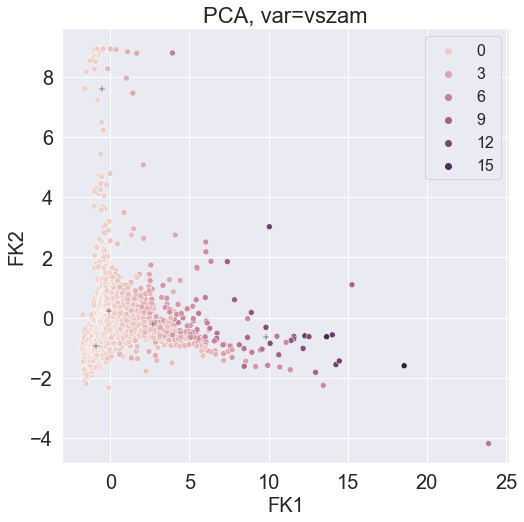

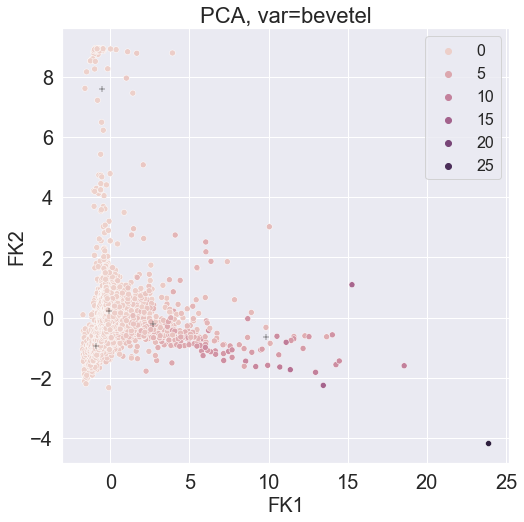

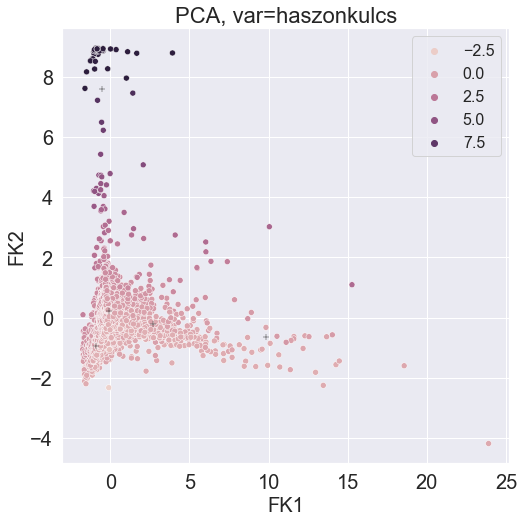

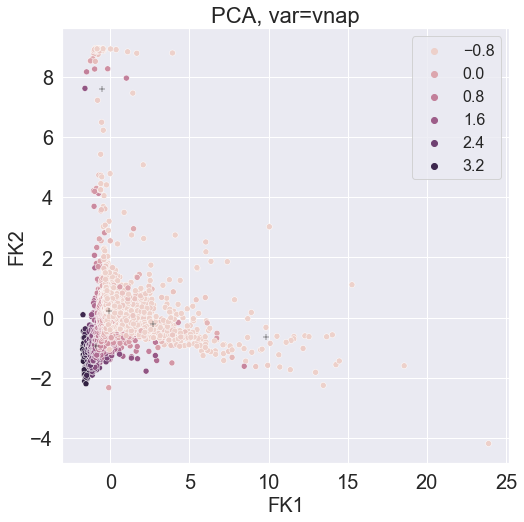

In [17]:
fs=20

create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns = [str(x) for x in range(pcd.shape[1])])

pca_frame = create_pca_frame(pca_data)

pca_frame['pred'] = pd.Series(y_pred) #Klaszterek 

# pca_frame['pred'] = pd.Series(y_pred_fuzzy) #Fuzzy C-means klaszterek

# pca_frame['pred'] = arak.reset_index()['cat'] #Árkategóriák

scaled_frame = create_pca_frame(scaled_termek)
for x,y in zip(range(4), ['vszam','bevetel','haszonkulcs','vnap']):    
    pca_frame['pred'] = scaled_frame[str(x)]

    #cluster center
    centers = kmeans.cluster_centers_
    pca_centers = pd.DataFrame(pca.transform(centers), columns=['0','1'])

    plt.figure(figsize=(8,8))
    plt.title('PCA, var='+y, size=fs+2)
    ax = scatter(x='0', y='1', hue='pred', data=pca_frame)
    ax = scatter(x='0', y='1', color=".2", marker="+", data=pca_centers)
    ax.legend(loc='upper right', fontsize=fs-4)
    ax.tick_params(labelsize=fs)
    ax.set_xlabel('FK1', size=fs)
    ax.set_ylabel('FK2', size=fs)
    plt.show()